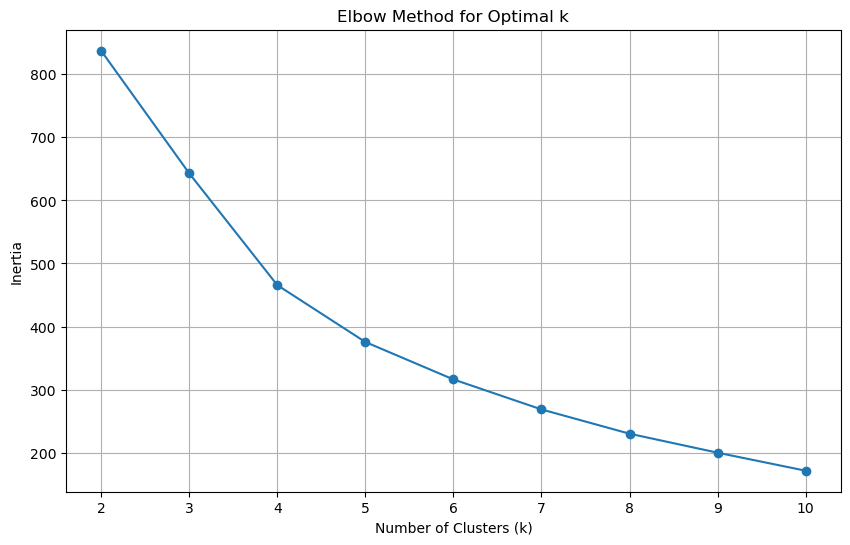

Number of clusters formed: 4
Davies-Bouldin Index: 0.9863


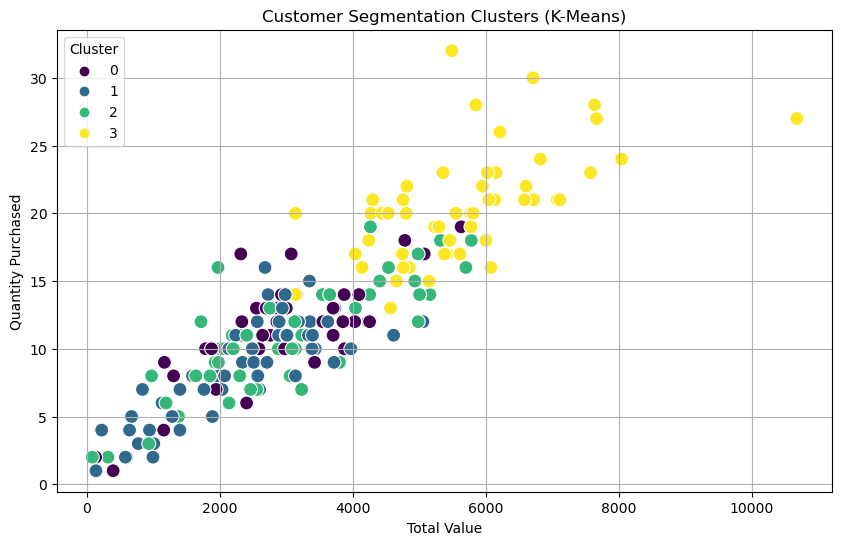

In [2]:
import os

# Set environment variable to avoid memory leak warning
os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

# Load datasets
customers = pd.read_csv(r'C:\Users\hp\Downloads\Customers.csv')
transactions = pd.read_csv(r'C:\Users\hp\Downloads\Transactions.csv')

# Merge datasets on CustomerID
merged_data = transactions.merge(customers, on='CustomerID')

# Feature Engineering
customer_features = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',           
    'TotalValue': 'sum',         
    'TransactionDate': 'count',   
    'Region': 'first',           
}).reset_index()

# Convert categorical variable 'Region' to numerical
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))

# Using K-Means for clustering
try:
    # Determine the optimal number of clusters using the Elbow Method
    inertia = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)  # Set n_init to 20
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 11), inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()

    # Choose the optimal number of clusters (e.g., 4 based on the elbow method)
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, n_init=20, random_state=42)
    customer_features['Cluster'] = kmeans.fit_predict(X_scaled)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(X_scaled, customer_features['Cluster'])

    # Print the results
    print(f'Number of clusters formed: {optimal_k}')
    print(f'Davies-Bouldin Index: {db_index:.4f}')

    # Visualize the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=customer_features['TotalValue'], y=customer_features['Quantity'], hue=customer_features['Cluster'], palette='viridis', s=100)
    plt.title('Customer Segmentation Clusters (K-Means)')
    plt.xlabel('Total Value')
    plt.ylabel('Quantity Purchased')
    plt.legend(title='Cluster')
    plt.grid()
    plt.show()

except Exception as e:
    print(f"K-Means encountered an error: {e}. Trying DBSCAN instead.")

    # Using DBSCAN as an alternative clustering method
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    customer_features['Cluster'] = dbscan.fit_predict(X_scaled)

    # Calculate Davies-Bouldin Index for DBSCAN
    if len(set(customer_features['Cluster'])) > 1:  # Check if there are at least 2 clusters
        db_index = davies_bouldin_score(X_scaled, customer_features['Cluster'])
        print(f'Davies-Bouldin Index (DBSCAN): {db_index:.4f}')
    else:
        print("DBSCAN did not form enough clusters.")

    # Visualize the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=customer_features['TotalValue'], y=customer_features['Quantity'], hue=customer_features['Cluster'], palette='viridis', s=100)
    plt.title('Customer Segmentation Clusters (DBSCAN)')
    plt.xlabel('Total Value')
    plt.ylabel('Quantity Purchased')
    plt.legend(title='Cluster')
    plt.grid()
    plt.show()
